In [220]:
import os
import glob

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import sklearn.metrics

import utils


from skl_dataset import SKLSwingDataset

from sklearn.metrics import confusion_matrix
import seaborn as sn

In [221]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [222]:
path = "data/"

shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]


In [223]:


# GENERATE DATA SPLITS
train = 0.75
val = 0.2
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

In [224]:
train_set = SKLSwingDataset(X_train, y_train)
val_set = SKLSwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SKLSwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)


In [225]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [226]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

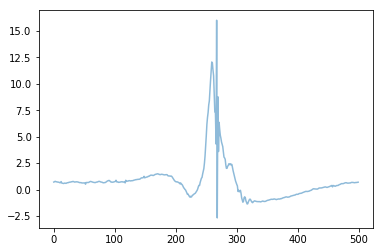

In [227]:
# Plot X_data
plt.plot(train_set.X_data[0][0],alpha=0.5)


In [254]:
#Training data
X_train = train_set.X_data
y_train = train_set.y_data

train_classes = [row[:-1] for row in y_train]
y_train = np.argmax(train_classes, axis=1)

#Reshape training data
n, nx, ny = X_train.shape
X_train = X_train.reshape((n,nx*ny))
  
    
    
    
#Test data    
X_test = test_set.X_data
y_test = test_set.y_data



print(len(y_test))

#Reshape test data
n, nx, ny = X_test.shape
X_test = X_test.reshape((n,nx*ny))

test_classes = [row[:-1] for row in y_test]
y_test = np.argmax(test_classes, axis=1)



        

5


In [229]:
#One-vs-one SVM with rbf kernel.
rbfsvm = svm.SVC(kernel='rbf', decision_function_shape='ovo',
                   gamma=1, C=1, probability=True).fit(X_train, y_train)
   
       

In [230]:
def print_predictions(predictions, truth, labels, n=10):
    for i in range(len(predictions)):
        p = predictions[i]
        t = truth[i]
        nLabels = len(labels)
        if i < n:
            if p >= 0 and p < nLabels:
                print("Predicted shot type is " + str(labels[p]))
                print("Real shot type is " + str(labels[t]) + "\n\n")
                
            else:
                print("Invalid shot class")
            
        else:
            return



predictions = rbfsvm.predict(X_test)

In [240]:
print_predictions(predictions, y_test, shot_types, 10)

Predicted shot type is Straight
Real shot type is Fade


Predicted shot type is Straight
Real shot type is Push-slice


Predicted shot type is Straight
Real shot type is Push-slice


Predicted shot type is Straight
Real shot type is Push-slice


Predicted shot type is Straight
Real shot type is Straight




[3 8 8 8 4]


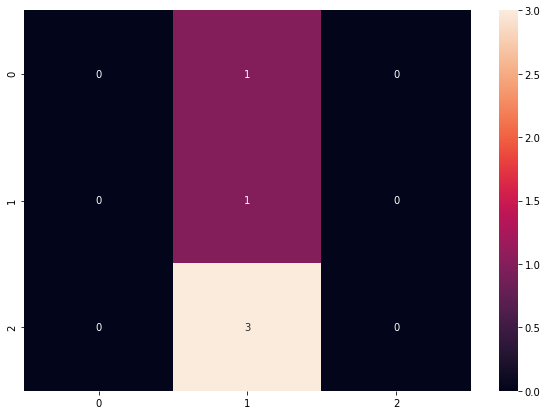

In [250]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
